In [2]:
## Standard Library
import os
import json

## External Libraries
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gc
from torchvision.models import resnet50
from PIL import Image
from itertools import groupby
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
label_present = []
for _ in range(15):
    label_present.append([])

In [4]:
label_index = {
    'bipolar dissector': 0,
    'bipolar forceps': 1,
    'cadiere forceps': 2,
    'clip applier ': 3,
    'force bipolar': 4,
    'grasping retractor': 5,
    'monopolar curved scissors': 6,
    'needle driver': 7,
    'needle driver2': 8,
    'permanent cautery hook/spatula': 9,
    'prograsp forceps': 10,
    'stapler': 11,
    'suction irrigator': 12,
    'tip-up fenestrated grasper': 13,
    'vessel sealer': 14
}
data = pd.read_csv('labels.csv')
label_onehot = np.zeros((data.shape[0], 15))
for index in range(data.shape[0]):
    tools = data['tools_present'][index][1:-1].replace('nan, ', '').split(', ')
    label_onehot[index][8] = 1 if tools.count('needle driver') > 1 else 0
    for j in range(3):
        label_onehot[index][label_index[tools[j]]] = 1
        label_present[label_index[tools[j]]].append(index)

In [5]:
label_onehot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [6]:
def get_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for di in dirs:
            file_paths.append(os.path.join(root, di))
    file_paths.sort(key=str.lower)
    return file_paths

class MultiLabelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Assuming each image filename contains a list of class labels
        #self.image_paths = get_file_paths(self.root_dir)  # List of image file paths
        self.image_paths = []
        self.folder_path = []
        self.labels = []
        for folder in os.listdir(root_dir):
            if folder.startswith('clip_'):
                possible_masked_png_path = os.path.join(root_dir, folder, '0')
                if os.path.exists(os.path.join(root_dir, folder, '0', 'original_image.png')):
                    self.image_paths.append(possible_masked_png_path)
                    folder_number = int(folder.split('_')[-1])
                    self.labels.append(label_onehot[folder_number, :])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #img_path1 = os.path.join(self.image_paths[idx], 'masked_2_.png')
        img_path1 = os.path.join(self.image_paths[idx], 'original_image.png')
        img_path2 = os.path.join(self.image_paths[idx], 'parts_image.png')
        #img_path2 = os.path.join(img_path, 'parts_image.png')
        image1 = io.imread(img_path1)
        image2 = io.imread(img_path2)
        image2 = np.stack((image2,)*3, axis=-1)
        multiplied_image = np.multiply(image1, image2)
        if self.transform:
            multiplied_image = self.transform(multiplied_image)
        max_value = multiplied_image.max()
        if max_value > 0:
            multiplied_image = multiplied_image / max_value
        else:
            multiplied_image = multiplied_image
        random_colors = torch.rand_like(multiplied_image)
        black_pixel = (multiplied_image < 0.01).all(dim=0)
        multiplied_image[:, black_pixel] = random_colors[:, black_pixel]
        label = torch.FloatTensor(self.labels[idx])

        return multiplied_image, label


In [7]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(25),
    #transforms.ColorJitter(),
    transforms.Resize((300, 450)),
    transforms.ToTensor()
])


dataset = MultiLabelDataset(root_dir='./data/data2/training_data', transform=img_transform)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split to create datasets for training, validation, and test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

'''
model_resnet = resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 15),
    nn.Sigmoid()
)
'''
#model_resnet.fc = model_resnet.fc.cuda() if use_cuda else model_resnet.fc


'\nmodel_resnet = resnet50(weights="IMAGENET1K_V1")\nnum_ftrs = model_resnet.fc.in_features\nmodel_resnet.fc = nn.Sequential(\n    nn.Linear(num_ftrs, 15),\n    nn.Sigmoid()\n)\n'

In [8]:
data_iter = iter(val_dataloader)
first_batch = next(data_iter)
inputs, ratget = first_batch

In [9]:
random_noise = np.random.randint(0, 1, inputs[0].shape, dtype=np.uint8)

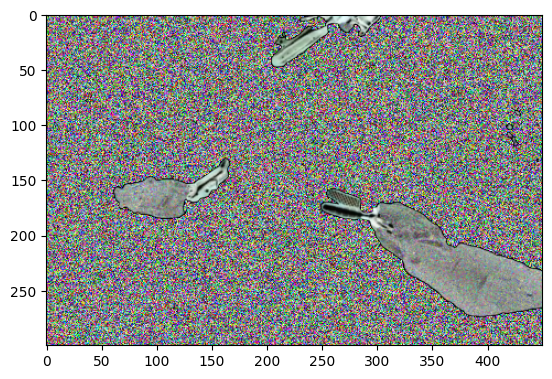

In [66]:
img_img = inputs[8].permute(1, 2, 0).cpu().detach()
plt.imshow(img_img)
plt.show()

In [11]:
class SpatialAttentionModule(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [12]:
class MFE(nn.Module):
    def __init__(self):
        super(MFE, self).__init__()
        self.conv1 = nn.Conv2d(256, 256, kernel_size=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv2d(2048, 256, kernel_size=1)

    def forward(self, feature1, feature2, feature3):
        f1 = self.conv1(feature1)
        f2 = self.conv2(feature2)
        f3 = self.conv3(feature3)

        f1_resized = F.adaptive_avg_pool2d(f1, (30, 30))
        f2_resized = F.adaptive_avg_pool2d(f2, (30, 30))
        f3_resized = F.adaptive_avg_pool2d(f3, (30, 30))

        fused_feature = f1_resized + f2_resized + f3_resized

        return fused_feature

In [13]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes=15):
        super(ModifiedResNet50, self).__init__()
        self.resnet = resnet50(weights="IMAGENET1K_V1")
        
        self.layer1 = nn.Sequential(*list(self.resnet.children())[:5]) 
        self.layer2 = nn.Sequential(*list(self.resnet.children())[5:6])
        self.layer3 = nn.Sequential(*list(self.resnet.children())[6:8])
        self.layer4 = nn.Sequential(*list(self.resnet.children())[8:9])
        
        
        self.attention1 = SpatialAttentionModule()
        self.attention2 = SpatialAttentionModule()
        self.attention3 = SpatialAttentionModule()
        
        num_ftrs = self.resnet.fc.in_features
        self.fc = nn.Sequential(
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )
        self.mfe = MFE()
        self.weight_init()
        self.fused_feature = None
        
    def weight_init(self):
        nn.init.kaiming_normal_(self.fc[0].weight)
        nn.init.constant_(self.fc[0].bias, 0)

    def forward(self, x):
        # 通过 ResNet 提取特征
        feature1 = self.layer1(x)
        #attention1 = self.attention1(feature1)
        #feature1 = feature1 * attention1
        feature2 = self.layer2(feature1)
        attention2 = self.attention2(feature2)
        feature2 = feature2 * attention2
        feature3 = self.layer3(feature2)
        attention3 = self.attention3(feature3)
        feature3 = feature3 * attention3
        self.fused_feature = self.mfe(feature1, feature2, feature3)
        gap_feature = self.layer4(self.fused_feature)
        #flattened_feature = self.fused_feature.view(self.fused_feature.size(0), -1)
        gap_feature = gap_feature.view(gap_feature.size(0), -1)
        #print(feature3.shape)
        out = self.fc(gap_feature)
        
        return out

In [14]:
torch.cuda.empty_cache()

In [15]:
num_epochs = 10
loss_fn = nn.BCELoss()
model_resnet = ModifiedResNet50(num_classes=15)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda:0")
model_resnet = model_resnet.to(device)
best_model = None
best_acc = 0

In [16]:
# Training loop
train_history = {
    "train": [],
    "acc": []
}

val_history = {
    "train": [],
    "acc": []
}
for epoch in range(num_epochs):
    model_resnet.train()
    total_loss = 0.0
    num_correct = 0
    num_samples = 0
    for batch in train_dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
        total_loss += loss.item()
        
        _, top3_indices = outputs.topk(3, dim=1)
        selected_onehot = torch.gather(torch.tensor(targets), 1, top3_indices)
        num_correct += (selected_onehot).sum()
        num_samples += outputs.size(0) * 3
        #print(outputs[0])
        #print(targets[0])
        #print(top3_indices[0])
        #print(selected_onehot)
        #print((selected_onehot).sum())
        #print(loss)
        #print(float(num_correct) / float(num_samples))

    average_loss = total_loss / len(train_dataloader)
    train_history['train'].append(average_loss)
    train_history['acc'].append(float(num_correct) / float(num_samples))
    print(f'Epoch [{epoch + 1}/{num_epochs}], TrainLoss: {average_loss:.4f}, TrainAccuracy: {float(num_correct) / float(num_samples) * 100:.2f}%')
    
    model_resnet.eval()
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        val_loss = 0.0
        for batch_idx, (data,targets) in enumerate(val_dataloader):
            data = data.to(device)
            targets = targets.to(device)
            scores = model_resnet(data)
            _, top3_indices = scores.topk(3, dim=1)
            selected_onehot = torch.gather(torch.tensor(targets), 1, top3_indices)
            num_correct += (selected_onehot).sum()
            num_samples += scores.size(0) * 3
        acc = float(num_correct) / float(num_samples)
        if (acc > best_acc):
            best_model = model_resnet
            best_acc = acc
        print(f"ValAccuracy : {acc * 100:.2f}%")

C:\Users\Worst\AppData\Local\Temp\ipykernel_12036\1266905249.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  selected_onehot = torch.gather(torch.tensor(targets), 1, top3_indices)


Epoch [1/10], TrainLoss: 0.2426, TrainAccuracy: 75.99%


C:\Users\Worst\AppData\Local\Temp\ipykernel_12036\1266905249.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  selected_onehot = torch.gather(torch.tensor(targets), 1, top3_indices)


ValAccuracy : 60.62%
Epoch [2/10], TrainLoss: 0.1820, TrainAccuracy: 81.82%
ValAccuracy : 70.62%
Epoch [3/10], TrainLoss: 0.1533, TrainAccuracy: 85.74%
ValAccuracy : 79.01%
Epoch [4/10], TrainLoss: 0.1460, TrainAccuracy: 86.36%
ValAccuracy : 70.49%
Epoch [5/10], TrainLoss: 0.1543, TrainAccuracy: 85.56%
ValAccuracy : 65.31%
Epoch [6/10], TrainLoss: 0.1511, TrainAccuracy: 85.46%
ValAccuracy : 74.44%
Epoch [7/10], TrainLoss: 0.1332, TrainAccuracy: 87.38%
ValAccuracy : 82.96%
Epoch [8/10], TrainLoss: 0.1383, TrainAccuracy: 86.85%
ValAccuracy : 69.88%
Epoch [9/10], TrainLoss: 0.1341, TrainAccuracy: 87.41%
ValAccuracy : 83.09%
Epoch [10/10], TrainLoss: 0.1298, TrainAccuracy: 87.72%
ValAccuracy : 82.22%


In [33]:
torch.save(best_model, 'pre_trained.pkl')

In [17]:
def return_CAM(feature_conv, weight, class_idx):
    size_upsample = (450, 300)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in range(class_idx):
        beforeDot =  feature_conv.reshape((bz, nc, h*w))
        cam = np.matmul(fc_weights[idx].cpu().detach().numpy(), beforeDot.cpu().detach().numpy())
        cam = cam.reshape(bz, h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        resized_cam_img = []
        for i in range(cam_img.shape[0]):
            resized_cam_img.append(cv2.resize(cam_img[i], size_upsample))
        output_cam.append(resized_cam_img)
    return output_cam

In [22]:
data_iter = iter(train_dataloader)
first_batch = next(data_iter)
inputs, target = first_batch
inputs, target = inputs.cuda(), ratget.cuda()
outputs = best_model(inputs)
class_idx = 1

In [23]:
fc_weights = best_model.fc[0].weight.data
feature= best_model.fused_feature
cam = return_CAM(feature, fc_weights, 15)

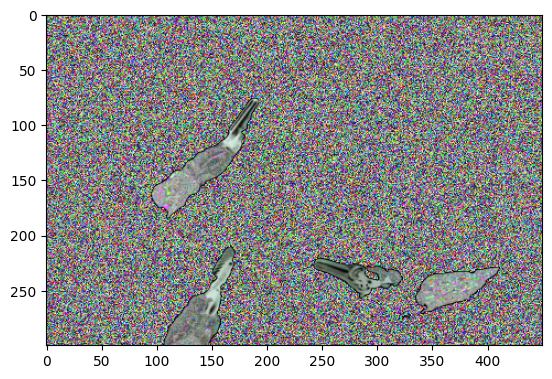

In [31]:
img_img = inputs[index].permute(1, 2, 0).cpu().detach()
plt.imshow(img_img)
plt.show()

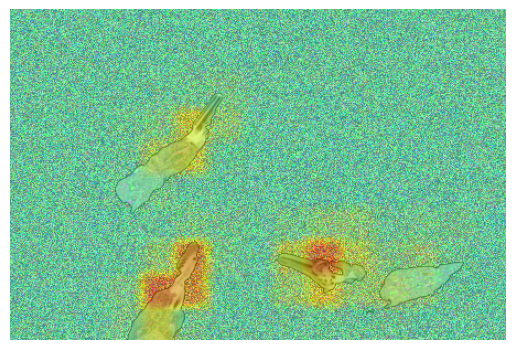

In [30]:
index = 5
org = inputs[index].cpu()
org = org * 255
org = org.numpy().astype(np.uint8)
org = np.transpose(org, (1, 2, 0))
cam_img = cv2.applyColorMap(cam[class_idx][index], cv2.COLORMAP_JET)
overlayed_image = cv2.addWeighted(org, 0.5, cam_img, 0.5, 0)
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()